In [20]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import helium

plotdir = '../../cvxportfolio/portfolio/plots/'
datadir='../../cvxportfolio/data/'

sigmas=pd.read_csv(datadir+'sigmas.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]
returns=pd.read_csv(datadir+'returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]

#, 'NKE', 'IBM', 'BAC', 'C'
subset_tickers = ['AMZN', 'GOOGL', 'BAC', 'USDOLLAR']
sigmas = sigmas.ix[:, sigmas.columns.isin(subset_tickers)]
returns = returns.ix[:, returns.columns.isin(subset_tickers)]
volumes = volumes.ix[:, volumes.columns.isin(subset_tickers)]

start_date="2012-02-01"
end_date="2016-12-31"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [22]:
cash_ticker = "_CASH"

In [23]:
sigmas[cash_ticker] = 0.
returns = returns.rename(columns={"USDOLLAR": cash_ticker})
volumes[cash_ticker] = np.finfo(np.float).max

In [24]:
w_b = pd.Series(index=returns.columns, data=1)
w_b._CASH = 0.
w_b/=sum(w_b)


In [25]:
return_estimate=pd.read_csv(datadir+'return_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()
volume_estimate=pd.read_csv(datadir+'volume_estimate.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1].dropna()
sigma_estimate=pd.read_csv(datadir+'sigma_estimate.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1].dropna()

return_estimate = return_estimate.ix[:, return_estimate.columns.isin(subset_tickers)]
volume_estimate = volume_estimate.ix[:, volume_estimate.columns.isin(subset_tickers)]
sigma_estimate = sigma_estimate.ix[:, sigma_estimate.columns.isin(subset_tickers)]

/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


In [26]:
sigma_estimate[cash_ticker] = 0.
return_estimate = return_estimate.rename(columns={"USDOLLAR": cash_ticker})
volume_estimate[cash_ticker] = np.finfo(np.float).max

In [27]:
borrow_costs = returns.copy()
borrow_costs[:] = 1E-4
borrow_costs[cash_ticker] = 0.

dividends = returns.copy()
dividends[:] = 0.

simulated_hcost=helium.HoldingCost(gamma = 1., borrow_costs=borrow_costs, dividends=dividends)
simulated_tcost=helium.TransactionCost(gamma =1.0, 
                                             half_spread=0.0005/2,
                                             nonlin_coef = 1.,
                                             sigmas = sigmas, 
                                             nonlin_power = 1.5,
                                             volumes = volumes,
                                             asym_coef = 0.)

simulator = helium.MarketSimulator(returns, volumes, costs=[simulated_tcost, simulated_hcost], cash_ticker=cash_ticker)

In [28]:
deltas = return_estimate.copy()
deltas[:]  = 0.
r= helium.DefaultRet(return_estimate, deltas = deltas, gamma_decay=None)

Sigma_hat = returns.rolling(window=250, min_periods=250).cov().unstack().shift(1).stack().dropna()

In [29]:
sigmas.head()

,GOOGL,AMZN,BAC,_CASH
Date,,,,
2007-01-03,0.003406,0.000517,0.001312,0.0
2007-01-04,0.029950,0.008001,0.006355,0.0
2007-01-05,0.009673,0.009080,0.006552,0.0
2007-01-08,0.008463,0.019020,0.000187,0.0
2007-01-09,0.000103,0.004776,0.001867,0.0


In [31]:
sigma_estimate.head()

,GOOGL,AMZN,BAC,_CASH
Date,,,,
2007-01-03,0.003406,0.000517,0.001312,0.0
2007-01-04,0.016680,0.004259,0.003833,0.0
2007-01-05,0.014340,0.005866,0.004740,0.0
2007-01-08,0.012870,0.009154,0.003602,0.0
2007-01-09,0.010320,0.008278,0.003255,0.0


In [45]:
sigma_estimate["2012-02"]

,GOOGL,AMZN,BAC,_CASH
Date,,,,
2012-02-01,0.006941,0.01346,0.01752,0.0
2012-02-02,0.006761,0.01275,0.01426,0.0
2012-02-03,0.006944,0.01526,0.01487,0.0
2012-02-06,0.009201,0.01446,0.01555,0.0
2012-02-07,0.008340,0.01423,0.01432,0.0
2012-02-08,0.007140,0.01408,0.01437,0.0
2012-02-09,0.006551,0.01224,0.01391,0.0
2012-02-10,0.005277,0.01222,0.01305,0.0
2012-02-13,0.005493,0.01376,0.01245,0.0


In [49]:
policies = {}
results = {}
gamma_risks_coarse=[.1, .3]#,1,3,10,30,100,300,1000]
gamma_tcosts_coarse=[1.,2.]#,5,10,20]
for gamma_risk in gamma_risks_coarse:
    for gamma_tcost in gamma_tcosts_coarse: 
        risk_model = helium.BasicRiskCost(gamma_risk, Sigma_hat)
        optimization_hcost = helium.HoldingCost(gamma = 1., borrow_costs=borrow_costs, dividends=dividends)
        optimization_tcost = helium.TransactionCost(gamma_tcost, 
                                                    half_spread=0.0005/2., 
                                                    nonlin_coef = 1.,
                                                    sigmas = sigma_estimate, 
                                                    nonlin_power = 1.5,
                                                    volumes = volume_estimate,
                                                    asym_coef = 0.)
        
        # issue optimization_tcost
        costs = [risk_model, optimization_tcost, optimization_hcost]
        const = [helium.LeverageLimitConstraint(3)]
        policies[(gamma_risk, gamma_tcost)] = helium.SinglePeriodOpt(r, costs, const)
        results[(gamma_risk, gamma_tcost)] = simulator.run(1E8*w_b, 
                                                         policies[(gamma_risk, gamma_tcost)],
                                                         start_date, 
                                                         end_date)

INFO:root:Backtest started, from 2012-02-01 00:00:00 to 2016-12-30 00:00:00
INFO:root:Getting trades at date: 2012-02-01 00:00:00
INFO:root:Propagating portfolio at time 2012-02-01 00:00:00
INFO:root:Getting trades at date: 2012-02-02 00:00:00
INFO:root:Propagating portfolio at time 2012-02-02 00:00:00
INFO:root:Getting trades at date: 2012-02-03 00:00:00
INFO:root:Propagating portfolio at time 2012-02-03 00:00:00
INFO:root:Getting trades at date: 2012-02-06 00:00:00
INFO:root:Propagating portfolio at time 2012-02-06 00:00:00
INFO:root:Getting trades at date: 2012-02-07 00:00:00
INFO:root:Propagating portfolio at time 2012-02-07 00:00:00
INFO:root:Getting trades at date: 2012-02-08 00:00:00
INFO:root:Propagating portfolio at time 2012-02-08 00:00:00
INFO:root:Getting trades at date: 2012-02-09 00:00:00
INFO:root:Propagating portfolio at time 2012-02-09 00:00:00
INFO:root:Getting trades at date: 2012-02-10 00:00:00


******
h:GOOGL    3.333333e+07
AMZN     3.333333e+07
BAC      3.333333e+07
_CASH    0.000000e+00
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.726e-03]
 [-3.777e-03]
 [ 1.420e-03]
 [ 2.400e-06]], [[0.33333333]
 [0.33333333]
 [0.33333333]
 [0.        ]] + var18318)) + -0 + 0.1 * 0 + 0.0016093123671364908 * quad_over_lin([[ 3.60031787e-10 -1.45288212e-10 -5.03191338e-11  3.67177513e-05]
 [ 3.16817925e-01 -1.72687172e-01 -3.79982048e-02 -3.84190114e-06]
 [ 2.14864591e-01  4.49891585e-01 -2.53105417e-01 -6.73521197e-07]
 [-2.99721815e-01 -3.55033085e-01 -8.85504569e-01  3.20538017e-07]] * [[0.33333333]
 [0.33333333]
 [0.33333333]
 [0.        ]] + var18318, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var18318[:-1, 0])) + 5 + [[0.04038156]
 [0.06950509]
 [0.05229137]] * [[0.006941]
 [0.01346 ]
 [0.01752 ]].T * power(abs(var18318[:-1, 0]), 3/2)) + 1.0 * sum_entries(mul_elemwise([[0.0001]
 [0.0001]
 [0.0001]], --max_elemwise(-[[0.33333333]
 [0.33333333]
 [0.33333333]
 [0.        ]] + 

INFO:root:Propagating portfolio at time 2012-02-10 00:00:00
INFO:root:Getting trades at date: 2012-02-13 00:00:00
INFO:root:Propagating portfolio at time 2012-02-13 00:00:00
INFO:root:Getting trades at date: 2012-02-14 00:00:00
INFO:root:Propagating portfolio at time 2012-02-14 00:00:00
INFO:root:Getting trades at date: 2012-02-15 00:00:00
INFO:root:Propagating portfolio at time 2012-02-15 00:00:00
INFO:root:Getting trades at date: 2012-02-16 00:00:00
INFO:root:Propagating portfolio at time 2012-02-16 00:00:00
INFO:root:Getting trades at date: 2012-02-17 00:00:00
INFO:root:Propagating portfolio at time 2012-02-17 00:00:00
INFO:root:Getting trades at date: 2012-02-21 00:00:00
INFO:root:Propagating portfolio at time 2012-02-21 00:00:00
INFO:root:Getting trades at date: 2012-02-22 00:00:00
INFO:root:Propagating portfolio at time 2012-02-22 00:00:00
INFO:root:Getting trades at date: 2012-02-23 00:00:00


GOOGL   -0.662672
AMZN    -0.496964
BAC      0.506608
_CASH    0.653027
dtype: float64
******
******
h:GOOGL    4.173054e-01
AMZN    -6.012913e+07
BAC     -4.326707e+07
_CASH    2.073558e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.651e-03]
 [ 1.024e-04]
 [ 2.495e-03]
 [ 4.400e-06]], [[ 4.01411107e-09]
 [-5.78389355e-01]
 [-4.16191118e-01]
 [ 1.99458047e+00]] + var18542)) + -0 + 0.1 * 0 + 0.0016268370681919383 * quad_over_lin([[ 2.72030175e-10 -1.69161030e-11 -5.77266141e-11  3.29216021e-05]
 [ 3.25253618e-01 -1.63468335e-01 -4.50481442e-02 -2.85054543e-06]
 [ 1.99669988e-01  4.67055117e-01 -2.53181048e-01 -1.85382211e-06]
 [-2.99877353e-01 -3.52363119e-01 -8.86517798e-01  7.42351698e-07]] * [[ 4.01411107e-09]
 [-5.78389355e-01]
 [-4.16191118e-01]
 [ 1.99458047e+00]] + var18542, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var18542[:-1, 0])) + 5 + [[0.07189813]
 [0.06529658]
 [0.04495731]] * [[0.005493]
 [0.01376 ]
 [0.01245 ]].T * power(abs(var18542[:-1, 0]), 3/2)) + 1.0 

INFO:root:Propagating portfolio at time 2012-02-23 00:00:00
INFO:root:Getting trades at date: 2012-02-24 00:00:00
INFO:root:Propagating portfolio at time 2012-02-24 00:00:00
INFO:root:Getting trades at date: 2012-02-27 00:00:00
INFO:root:Propagating portfolio at time 2012-02-27 00:00:00
INFO:root:Getting trades at date: 2012-02-28 00:00:00
INFO:root:Propagating portfolio at time 2012-02-28 00:00:00
INFO:root:Getting trades at date: 2012-02-29 00:00:00
INFO:root:Propagating portfolio at time 2012-02-29 00:00:00
INFO:root:Getting trades at date: 2012-03-01 00:00:00
INFO:root:Propagating portfolio at time 2012-03-01 00:00:00
INFO:root:Getting trades at date: 2012-03-02 00:00:00



constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1))), EqConstraint(Expression(AFFINE, UNKNOWN, (1, 1)), Constant(CONSTANT, ZERO, (1, 1)))]
GOOGL    0.311142
AMZN    -1.778099
BAC      0.398489
_CASH    1.068468
dtype: float64
******
******
h:GOOGL    4.255345e+00
AMZN    -9.748738e+07
BAC      1.643252e+08
_CASH    3.375801e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.354e-03]
 [ 1.200e-03]
 [-4.554e-03]
 [ 4.000e-06]], [[ 4.23014072e-08]
 [-9.69099685e-01]
 [ 1.63351905e+00]
 [ 3.35580593e-01]] + var18766)) + -0 + 0.1 * 0 + 0.0016332040521102726 * quad_over_lin([[ 2.44141348e-10 -4.08583479e-11 -5.39197919e-11  3.16313483e-05]
 [ 3.26506600e-01 -1.60343351e-01 -4.58015435e-02 -2.80527832e-06]
 [ 1.96573736e-01  4.72160488e-01 -2.51632843e-01 -1.33627152e-06]
 [-2.96558230e-01 -3.50072082e-01 -8.88539675e-01  3.22113507e-07]] * [[ 4.23014072e-08]
 [-9.69099685e-01]
 [ 1.63351905e+00]
 [ 3.35580593e-01]] + var18766, 1) + 1.0 *

INFO:root:Propagating portfolio at time 2012-03-02 00:00:00
INFO:root:Getting trades at date: 2012-03-05 00:00:00
INFO:root:Propagating portfolio at time 2012-03-05 00:00:00
INFO:root:Getting trades at date: 2012-03-06 00:00:00
INFO:root:Propagating portfolio at time 2012-03-06 00:00:00
INFO:root:Getting trades at date: 2012-03-07 00:00:00
INFO:root:Propagating portfolio at time 2012-03-07 00:00:00
INFO:root:Getting trades at date: 2012-03-08 00:00:00
INFO:root:Propagating portfolio at time 2012-03-08 00:00:00
INFO:root:Getting trades at date: 2012-03-09 00:00:00
INFO:root:Propagating portfolio at time 2012-03-09 00:00:00
INFO:root:Getting trades at date: 2012-03-12 00:00:00
INFO:root:Propagating portfolio at time 2012-03-12 00:00:00
INFO:root:Getting trades at date: 2012-03-13 00:00:00
INFO:root:Propagating portfolio at time 2012-03-13 00:00:00
INFO:root:Getting trades at date: 2012-03-14 00:00:00
INFO:root:Propagating portfolio at time 2012-03-14 00:00:00


GOOGL   -2.398610
AMZN    -0.002628
BAC      0.036532
_CASH    2.364706
dtype: float64
******
******
h:GOOGL   -8.665526e+07
AMZN    -1.220808e+07
BAC      4.925749e+07
_CASH    1.487398e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[3.952e-03]
 [3.013e-03]
 [2.711e-03]
 [3.200e-06]], [[-0.87412321]
 [-0.12314736]
 [ 0.49687826]
 [ 1.50039232]] + var18934)) + -0 + 0.1 * 0 + 0.0016294925373640642 * quad_over_lin([[ 1.92920219e-10 -7.09595112e-11 -4.00390515e-11  2.96426402e-05]
 [ 3.26367408e-01 -1.60110748e-01 -4.46488547e-02 -2.56765084e-06]
 [ 1.97345351e-01  4.72365743e-01 -2.51378044e-01 -4.93141111e-07]
 [-2.93650270e-01 -3.50578644e-01 -8.89305422e-01 -1.29298889e-07]] * [[-0.87412321]
 [-0.12314736]
 [ 0.49687826]
 [ 1.50039232]] + var18934, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var18934[:-1, 0])) + 5 + [[0.07438463]
 [0.11116755]
 [0.06006533]] * [[0.005832]
 [0.007803]
 [0.01368 ]].T * power(abs(var18934[:-1, 0]), 3/2)) + 1.0 * sum_entries(mul_elemwise([[0.0001]

INFO:root:Getting trades at date: 2012-03-15 00:00:00
INFO:root:Propagating portfolio at time 2012-03-15 00:00:00
INFO:root:Getting trades at date: 2012-03-16 00:00:00
INFO:root:Propagating portfolio at time 2012-03-16 00:00:00
INFO:root:Getting trades at date: 2012-03-19 00:00:00
INFO:root:Propagating portfolio at time 2012-03-19 00:00:00
INFO:root:Getting trades at date: 2012-03-20 00:00:00
INFO:root:Propagating portfolio at time 2012-03-20 00:00:00
INFO:root:Getting trades at date: 2012-03-21 00:00:00
INFO:root:Propagating portfolio at time 2012-03-21 00:00:00
INFO:root:Getting trades at date: 2012-03-22 00:00:00
INFO:root:Propagating portfolio at time 2012-03-22 00:00:00
INFO:root:Getting trades at date: 2012-03-23 00:00:00
INFO:root:Propagating portfolio at time 2012-03-23 00:00:00
INFO:root:Getting trades at date: 2012-03-26 00:00:00


******
h:GOOGL   -9.177746e+07
AMZN     6.186505e+07
BAC      1.264379e+08
_CASH   -1.314094e+05
dtype: float64
Obj: sum_entries(mul_elemwise([[-5.988e-03]
 [-3.813e-03]
 [-3.678e-03]
 [ 3.200e-06]], [[-0.95210676]
 [ 0.64179297]
 [ 1.31167704]
 [-0.00136325]] + var19158)) + -0 + 0.1 * 0 + 0.0016484908937770496 * quad_over_lin([[ 1.72207581e-10 -8.23489654e-11 -4.37136501e-11  2.89656754e-05]
 [ 3.24009861e-01 -1.58962732e-01 -4.40550430e-02 -2.44472731e-06]
 [ 1.97129910e-01  4.70346407e-01 -2.47315960e-01 -2.08032720e-07]
 [-2.91326547e-01 -3.46709707e-01 -8.91583547e-01 -5.99223626e-07]] * [[-0.95210676]
 [ 0.64179297]
 [ 1.31167704]
 [-0.00136325]] + var19158, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var19158[:-1, 0])) + 5 + [[0.07525275]
 [0.1239146 ]
 [0.0428722 ]] * [[0.006972]
 [0.008792]
 [0.01646 ]].T * power(abs(var19158[:-1, 0]), 3/2)) + 1.0 * sum_entries(mul_elemwise([[0.0001]
 [0.0001]
 [0.0001]], --max_elemwise(-[[-0.95210676]
 [ 0.64179297]
 [ 1.31167704]
 [-0.0

INFO:root:Propagating portfolio at time 2012-03-26 00:00:00
INFO:root:Getting trades at date: 2012-03-27 00:00:00
INFO:root:Propagating portfolio at time 2012-03-27 00:00:00
INFO:root:Getting trades at date: 2012-03-28 00:00:00
INFO:root:Propagating portfolio at time 2012-03-28 00:00:00
INFO:root:Getting trades at date: 2012-03-29 00:00:00
INFO:root:Propagating portfolio at time 2012-03-29 00:00:00
INFO:root:Getting trades at date: 2012-03-30 00:00:00
INFO:root:Propagating portfolio at time 2012-03-30 00:00:00
INFO:root:Getting trades at date: 2012-04-02 00:00:00
INFO:root:Propagating portfolio at time 2012-04-02 00:00:00
INFO:root:Getting trades at date: 2012-04-03 00:00:00
INFO:root:Propagating portfolio at time 2012-04-03 00:00:00
INFO:root:Getting trades at date: 2012-04-04 00:00:00


******
h:GOOGL   -2.819506e+07
AMZN     2.034147e+07
BAC      5.999424e+07
_CASH    5.439907e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.881e-03]
 [-1.677e-03]
 [ 1.278e-03]
 [ 3.600e-06]], [[-0.26464368]
 [ 0.19092852]
 [ 0.56311623]
 [ 0.51059893]] + var19354)) + -0 + 0.1 * 0 + 0.0016794569974802882 * quad_over_lin([[ 1.81062754e-10 -7.85742645e-11 -6.90044560e-11  2.84128348e-05]
 [ 3.23177095e-01 -1.57603865e-01 -4.19000882e-02 -2.59707404e-06]
 [ 1.95818196e-01  4.65404962e-01 -2.40230166e-01 -5.44242819e-07]
 [-2.83393113e-01 -3.43026294e-01 -8.95556422e-01 -1.31766102e-06]] * [[-0.26464368]
 [ 0.19092852]
 [ 0.56311623]
 [ 0.51059893]] + var19354, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var19354[:-1, 0])) + 5 + [[0.07314771]
 [0.10768076]
 [0.02837924]] * [[0.008475]
 [0.01461 ]
 [0.02526 ]].T * power(abs(var19354[:-1, 0]), 3/2)) + 1.0 * sum_entries(mul_elemwise([[0.0001]
 [0.0001]
 [0.0001]], --max_elemwise(-[[-0.26464368]
 [ 0.19092852]
 [ 0.56311623]
 [ 0.5

INFO:root:Propagating portfolio at time 2012-04-04 00:00:00
INFO:root:Getting trades at date: 2012-04-05 00:00:00
INFO:root:Propagating portfolio at time 2012-04-05 00:00:00
INFO:root:Getting trades at date: 2012-04-09 00:00:00
INFO:root:Propagating portfolio at time 2012-04-09 00:00:00
INFO:root:Getting trades at date: 2012-04-10 00:00:00
INFO:root:Propagating portfolio at time 2012-04-10 00:00:00
INFO:root:Getting trades at date: 2012-04-11 00:00:00
INFO:root:Propagating portfolio at time 2012-04-11 00:00:00
INFO:root:Getting trades at date: 2012-04-12 00:00:00
INFO:root:Propagating portfolio at time 2012-04-12 00:00:00
INFO:root:Getting trades at date: 2012-04-13 00:00:00


GOOGL    0.157141
AMZN     0.004597
BAC     -0.170526
_CASH    0.008789
dtype: float64
******
******
h:GOOGL   -8.658090e+07
AMZN     1.298348e+07
BAC     -1.745855e+07
_CASH    1.977950e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.217e-03]
 [ 1.683e-03]
 [ 3.691e-04]
 [ 3.200e-06]], [[-0.81114557]
 [ 0.12163757]
 [-0.16356298]
 [ 1.85307098]] + var19578)) + -0 + 0.1 * 0 + 0.0016909431068233562 * quad_over_lin([[ 1.63415473e-10 -4.31638712e-11 -6.35079798e-11  2.84902221e-05]
 [ 3.21447934e-01 -1.52065522e-01 -4.40224045e-02 -2.17229182e-06]
 [ 1.89655480e-01  4.70127573e-01 -2.39101713e-01 -9.08556648e-07]
 [-2.84089031e-01 -3.41122604e-01 -8.96062939e-01 -8.84751823e-07]] * [[-0.81114557]
 [ 0.12163757]
 [-0.16356298]
 [ 1.85307098]] + var19578, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var19578[:-1, 0])) + 5 + [[0.07941469]
 [0.08921934]
 [0.05113809]] * [[0.006181]
 [0.01367 ]
 [0.0162  ]].T * power(abs(var19578[:-1, 0]), 3/2)) + 1.0 * sum_entries(mul_elemwise([[0.0

INFO:root:Propagating portfolio at time 2012-04-13 00:00:00
INFO:root:Getting trades at date: 2012-04-16 00:00:00
INFO:root:Propagating portfolio at time 2012-04-16 00:00:00
INFO:root:Getting trades at date: 2012-04-17 00:00:00
INFO:root:Propagating portfolio at time 2012-04-17 00:00:00
INFO:root:Getting trades at date: 2012-04-18 00:00:00
INFO:root:Propagating portfolio at time 2012-04-18 00:00:00
INFO:root:Getting trades at date: 2012-04-19 00:00:00
INFO:root:Propagating portfolio at time 2012-04-19 00:00:00
INFO:root:Getting trades at date: 2012-04-20 00:00:00
INFO:root:Propagating portfolio at time 2012-04-20 00:00:00
INFO:root:Getting trades at date: 2012-04-23 00:00:00
INFO:root:Propagating portfolio at time 2012-04-23 00:00:00
INFO:root:Getting trades at date: 2012-04-24 00:00:00


GOOGL    3.746519e-02
AMZN    -4.486072e-02
BAC     -8.193824e-09
_CASH    7.395535e-03
dtype: float64
******
******
h:GOOGL   -4.552299e+07
AMZN     1.982222e+08
BAC     -5.001192e+07
_CASH   -1.862607e+04
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.175e-03]
 [-1.933e-03]
 [ 2.939e-03]
 [ 3.200e-06]], [[-4.43397237e-01]
 [ 1.93069838e+00]
 [-4.87119719e-01]
 [-1.81419294e-04]] + var19746)) + -0 + 0.1 * 0 + 0.0017248007899673804 * quad_over_lin([[ 1.35370388e-10 -2.23439129e-11 -5.18596539e-11  2.97973875e-05]
 [ 3.10326209e-01 -1.37569521e-01 -4.43274266e-02 -1.59012684e-06]
 [ 1.75019124e-01  4.69546594e-01 -2.31962008e-01 -8.46730874e-07]
 [-2.78918022e-01 -3.39759526e-01 -8.98202762e-01 -5.50880535e-07]] * [[-4.43397237e-01]
 [ 1.93069838e+00]
 [-4.87119719e-01]
 [-1.81419294e-04]] + var19746, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var19746[:-1, 0])) + 5 + [[0.04674733]
 [0.12264643]
 [0.05133525]] * [[0.01137]
 [0.0107 ]
 [0.02104]].T * power(abs(var19746[:-1, 0]),

INFO:root:Propagating portfolio at time 2012-04-24 00:00:00
INFO:root:Getting trades at date: 2012-04-25 00:00:00
INFO:root:Propagating portfolio at time 2012-04-25 00:00:00
INFO:root:Getting trades at date: 2012-04-26 00:00:00
INFO:root:Propagating portfolio at time 2012-04-26 00:00:00
INFO:root:Getting trades at date: 2012-04-27 00:00:00
INFO:root:Propagating portfolio at time 2012-04-27 00:00:00
INFO:root:Getting trades at date: 2012-04-30 00:00:00
INFO:root:Propagating portfolio at time 2012-04-30 00:00:00
INFO:root:Getting trades at date: 2012-05-01 00:00:00
INFO:root:Propagating portfolio at time 2012-05-01 00:00:00
INFO:root:Getting trades at date: 2012-05-02 00:00:00
INFO:root:Propagating portfolio at time 2012-05-02 00:00:00
INFO:root:Getting trades at date: 2012-05-03 00:00:00
INFO:root:Propagating portfolio at time 2012-05-03 00:00:00
INFO:root:Getting trades at date: 2012-05-04 00:00:00


******
h:GOOGL   -7.215817e+07
AMZN     9.362236e+07
BAC      5.975143e+06
_CASH    7.732722e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.746e-03]
 [ 6.338e-03]
 [ 1.882e-03]
 [ 3.600e-06]], [[-0.68875201]
 [ 0.89362837]
 [ 0.05703292]
 [ 0.73809072]] + var19914)) + -0 + 0.1 * 0 + 0.0017316311846729392 * quad_over_lin([[ 1.68076690e-10 -3.24984281e-11 -5.43301883e-11  2.99842583e-05]
 [ 3.09107885e-01 -1.40439002e-01 -4.30708336e-02 -1.96296079e-06]
 [ 1.79998089e-01  4.67204792e-01 -2.31593994e-01 -9.22237482e-07]
 [-2.78863204e-01 -3.38118934e-01 -8.98838639e-01 -4.31960064e-07]] * [[-0.68875201]
 [ 0.89362837]
 [ 0.05703292]
 [ 0.73809072]] + var19914, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var19914[:-1, 0])) + 5 + [[0.04462571]
 [0.15059114]
 [0.05292016]] * [[0.012  ]
 [0.01017]
 [0.02164]].T * power(abs(var19914[:-1, 0]), 3/2)) + 1.0 * sum_entries(mul_elemwise([[0.0001]
 [0.0001]
 [0.0001]], --max_elemwise(-[[-0.68875201]
 [ 0.89362837]
 [ 0.05703292]
 [ 0.7380

INFO:root:Propagating portfolio at time 2012-05-04 00:00:00
INFO:root:Getting trades at date: 2012-05-07 00:00:00
INFO:root:Propagating portfolio at time 2012-05-07 00:00:00
INFO:root:Getting trades at date: 2012-05-08 00:00:00
INFO:root:Propagating portfolio at time 2012-05-08 00:00:00
INFO:root:Getting trades at date: 2012-05-09 00:00:00
INFO:root:Propagating portfolio at time 2012-05-09 00:00:00
INFO:root:Getting trades at date: 2012-05-10 00:00:00


GOOGL    0.262301
AMZN    -0.428837
BAC     -0.100977
_CASH    0.267513
dtype: float64
******
******
h:GOOGL    3.882207e+07
AMZN     2.280990e+08
BAC     -1.465687e+08
_CASH    2.913309e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 5.985e-03]
 [-2.559e-03]
 [ 4.679e-03]
 [ 4.000e-06]], [[ 0.25970472]
 [ 1.52589432]
 [-0.98048818]
 [ 0.19488915]] + var20166)) + -0 + 0.1 * 0 + 0.0017474734963646838 * quad_over_lin([[ 2.05689910e-10 -1.03722426e-10 -4.08092523e-11  3.09326825e-05]
 [ 3.25370059e-01 -1.20711364e-01 -5.43091793e-02 -2.63999511e-06]
 [ 1.45428524e-01  5.02249675e-01 -2.45062736e-01  3.93775996e-07]
 [-2.80311478e-01 -3.54159259e-01 -8.92186469e-01 -5.00650973e-07]] * [[ 0.25970472]
 [ 1.52589432]
 [-0.98048818]
 [ 0.19488915]] + var20166, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var20166[:-1, 0])) + 5 + [[0.12556531]
 [0.09335537]
 [0.11923237]] * [[0.008448]
 [0.01232 ]
 [0.01482 ]].T * power(abs(var20166[:-1, 0]), 3/2)) + 1.0 * sum_entries(mul_elemwise([[0.0

KeyboardInterrupt: 

In [61]:
result_df_coarse=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_coarse and k[1] in gamma_tcosts_coarse:
        result_df_coarse.loc[k[0], k[1]] = results[k]
        
result_df = result_df_coarse.loc[sorted(result_df_coarse.index), sorted(result_df_coarse.columns)]

[25.899866071491843, 21.91129018029715] [25.50731641472067, 20.70403156968799]
[19.40384174151566, 16.334377394614975] [21.42011404102147, 18.1838086247516]


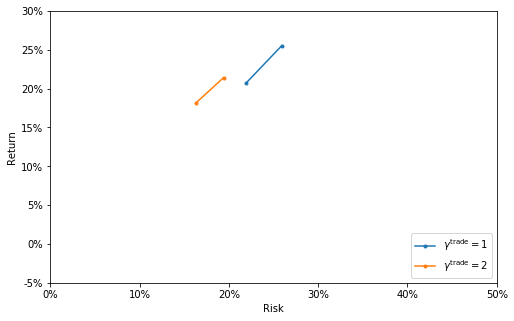

In [62]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,50])
plt.ylim([-5,30])


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier.png')